# Segmentation Workflow Overview

This notebook walks you through running Cellpose-based segmentation on Teton imaging runs. You will:
- select wells and tiles from the acquisition,
- choose compatible Cellpose models (2-channel or 3-channel depending on kit type), and
- generate per-tile cell/nucleus masks together with quick quality metrics and overlays.

**Prerequisites**
- Python 3.11 (pip 24.0) virtual environment.
- Cytoprofiling Installed from Github Link - https://github.com/Elembio/cytoprofiling/tree/main/src
- Packages installed with the versions we used during validation:
  - `cellpose==3.0.7`
  - `numpy==1.26.4`
  - `pandas==2.2.3`
  - `scikit-image==0.24.0`
  - `Pillow==10.4.0`
  - `ipywidgets==8.1.3`
  - `ipykernel==6.29.5`

Set up the environment and kernel:
```bash
python -m venv venv
venv\Scripts\activate  # On Windows; use 'source venv/bin/activate' on macOS/Linux
#Make Sure at this step you already have installed cytoprofling from the above mentioned link.
pip install cellpose==3.0.7 numpy==1.26.4 pandas==2.2.3 scikit-image==0.24.0 Pillow==10.4.0 ipywidgets==8.1.3 ipykernel==6.29.5
python -m ipykernel install --user --name cytoprofiling-seg --display-name "Cytoprofiling Segmentation"
```
Then select the **Cytoprofiling Segmentation ** kernel before running the notebook.

In [1]:
import json
import os
import sys
from pathlib import Path


import segmentation as segmentation_module
from segmentation import (
    run_segmentation,
    TILE_MAPS,
    WELL_LAYOUT_MAP,
    is_two_channel_model,
)

## Load Notebook Helpers
Run the next (collapsed) cell once to register the widget helpers and shared constants used later in the workflow.

In [2]:
import ipywidgets as widgets
from IPython.display import HTML, clear_output, display

VALID_KIT_TYPES = {
    "KitTypeCytoprofiling",
    "KitTypeAntibodyScreening",
    "KitTypeDirectInSampleSequencing",
}

LAYOUT_IMAGE_MAP = {
    "TwelveWellStandard": "Teton_12_well_layout.png",
    "OneWell": "Teton_1_well_layout.png",
    "FortyEightWell": "Teton_48_well_layout.png",
}

SEGMENTATION_IMAGE_DIR = Path(segmentation_module.__file__).resolve().parent / "Images"


def load_run_parameters(input_folder):
    runparam_path = Path(input_folder) / "RunParameters.json"
    if not runparam_path.exists():
        raise FileNotFoundError(f"RunParameters.json not found in {input_folder}")
    with runparam_path.open("r") as f:
        return json.load(f)


def interactive_well_tile_selector(input_folder):
    run_parameters = load_run_parameters(input_folder)
    layout = run_parameters.get("WellLayout")
    if layout is None:
        raise ValueError("WellLayout missing from RunParameters.json")
    if layout not in WELL_LAYOUT_MAP:
        raise ValueError(f"Unsupported WellLayout value: {layout}")
    kit_type = run_parameters.get("KitType")
    if kit_type is None:
        raise ValueError("KitType missing from RunParameters.json")
    if kit_type not in VALID_KIT_TYPES:
        raise ValueError(f"Unsupported KitType value: {kit_type}")

    wells = WELL_LAYOUT_MAP[layout]
    print(f"Detected layout: {layout} | Kit type: {kit_type}")

    layout_image_name = LAYOUT_IMAGE_MAP.get(layout)
    if layout_image_name:
        image_path = SEGMENTATION_IMAGE_DIR / layout_image_name
        if image_path.exists():
            with image_path.open("rb") as img_file:
                image_widget = widgets.Image(value=img_file.read(), format="png")
                image_widget.layout = widgets.Layout(width="600px")
            display(
                widgets.HBox(
                    [image_widget],
                    layout=widgets.Layout(justify_content="center", margin="0 0 10px 0"),
                )
            )
        else:
            print(f"Layout image not found at {image_path}")

    well_select = widgets.SelectMultiple(
        options=wells,
        description="Select wells",
        rows=min(12, len(wells)),
        layout=widgets.Layout(width="40%"),
    )

    tile_select = widgets.SelectMultiple(
        options=[],
        description="Select tiles",
        rows=12,
        layout=widgets.Layout(width="55%"),
    )

    cell_diameter_input = widgets.Text(
        value="",
        description="General diameters",
        placeholder="e.g. 30, 45",
        tooltip="Comma-separated pixel diameters; used only by general models.",
        layout=widgets.Layout(width="40%"),
    )

    optimize_checkbox = widgets.Checkbox(
        value=True,
        description="Optimize (crop tiles for speed)",
        tooltip="When enabled, crops each tile to a centered 1824x1824 window before segmentation.",
        layout=widgets.Layout(width="40%"),
    )

    out = widgets.Output()
    selection = {"kit_type": kit_type}

    def on_well_change(change):
        selected = list(change["new"])
        tiles = []
        for w in selected:
            tiles.extend(TILE_MAPS[layout].get(w, []))
        tiles = sorted(tiles)
        tile_select.options = tiles
        with out:
            clear_output()
            print(f"Selected wells: {selected}")
            print(f"Number of tiles available: {len(tiles)}")
            if len(tiles) <= 50:
                print("Example tiles:", tiles[:10])

    well_select.observe(on_well_change, names="value")

    confirm_btn = widgets.Button(description="Confirm selection", button_style="success")
    selection_out = widgets.Output()

    def on_confirm(_):
        with selection_out:
            clear_output()
            chosen_wells = list(well_select.value)
            chosen_tiles = list(tile_select.value)
            raw_diameter_value = (cell_diameter_input.value or "").strip()
            diameter_vals = []
            if raw_diameter_value:
                parts = [part.strip() for part in raw_diameter_value.split(",")]
                try:
                    diameter_vals = [float(part) for part in parts if part]
                except ValueError:
                    print("Please enter diameters as comma-separated positive numbers.")
                    return
                if any(val <= 0 for val in diameter_vals):
                    print("Diameters must be positive numbers.")
                    return
            if not chosen_wells:
                print("Please select at least one well.")
                return
            if not chosen_tiles:
                print("Please select at least one tile.")
                return

            selection.update(
                {
                    "layout": layout,
                    "wells": chosen_wells,
                    "tiles": chosen_tiles,
                    "cell_diameters": diameter_vals,
                    "optimize_crop": bool(optimize_checkbox.value),
                }
            )
            print("Selection confirmed.")
            print("Wells:", chosen_wells)
            print("Tiles:", len(chosen_tiles))
            if diameter_vals:
                print(f"General model diameters (px): {diameter_vals}")
            else:
                print("General model diameters (px): none provided (only required for general models).")
            print(f"Optimize cropping: {bool(optimize_checkbox.value)}")

    confirm_btn.on_click(on_confirm)

    controls = widgets.VBox([
        widgets.HBox([well_select, tile_select]),
        cell_diameter_input,
        optimize_checkbox,
    ])

    display(controls, out, confirm_btn, selection_out)
    return selection, well_select, tile_select, confirm_btn, selection_out


def model_selection_widget(model_dir, cell_model_filter=None, nuclear_model_filter=None, kit_type=None):
    if kit_type is not None and kit_type not in VALID_KIT_TYPES:
        raise ValueError(f"Unsupported KitType value: {kit_type}")

    if not os.path.isdir(model_dir):
        raise FileNotFoundError(f"Model directory not found: {model_dir}")

    candidates = sorted([name for name in os.listdir(model_dir) if not name.startswith('.')])
    if not candidates:
        raise ValueError(f"No models found in {model_dir}")

    effective_cell_filter = cell_model_filter
    if kit_type == "KitTypeAntibodyScreening":
        if effective_cell_filter is None:
            effective_cell_filter = is_two_channel_model
        else:
            base_filter = effective_cell_filter

            def combined_filter(name, base_filter=base_filter):
                return base_filter(name) and is_two_channel_model(name)

            effective_cell_filter = combined_filter

    cell_opts = [name for name in candidates if (effective_cell_filter(name) if effective_cell_filter else True)]
    nuclear_opts = [name for name in candidates if (nuclear_model_filter(name) if nuclear_model_filter else True)]

    if not nuclear_opts:
        nuclear_opts = candidates.copy()

    if not cell_opts:
        raise ValueError("No cell models available after applying kit-type filter.")

    cell_select = widgets.SelectMultiple(
        options=cell_opts,
        description="Cell models",
        rows=min(10, len(cell_opts)),
        layout=widgets.Layout(width="50%"),
    )

    nuclear_select = widgets.Dropdown(
        options=nuclear_opts,
        description="Nuclear model",
        layout=widgets.Layout(width="50%"),
    )

    confirm_btn = widgets.Button(description="Confirm models", button_style="success")
    out = widgets.Output()
    selected = {}

    def on_confirm(_):
        with out:
            clear_output()
            chosen_cell = list(cell_select.value)
            chosen_nuclear = nuclear_select.value
            if not chosen_cell:
                print("Please select at least one cell model.")
                return
            if chosen_nuclear is None:
                print("Please select a nuclear model.")
                return
            selected["cell_models"] = chosen_cell
            selected["nuclear_model"] = chosen_nuclear
            print("Models confirmed.")
            print("Cell models:", chosen_cell)
            print("Nuclear model:", chosen_nuclear)

    confirm_btn.on_click(on_confirm)

    display(widgets.HBox([cell_select, nuclear_select]))
    display(widgets.HBox([confirm_btn]), out)

    return selected

## Provide Input and Output Paths
- `Run_directory` should point to a Teton run folder with `Projection/` images (Cell-Membrane, Nucleus, Actin) and `RunParameters.json`. These files determine well layout, kit type, and available tiles.
- `output_location` is the root folder for segmentation outputs. If you pick multiple cell models, the notebook writes each model's masks to separate subdirectories so they can be consumed directly by Cells2Stats (the downstream analysis pipeline).

In [ ]:
# Input Run Directory
Run_directory = r"C:\Users\lab\Desktop\AVXXXXX\202XXXXX_Teton_Training"
output_location = r"C:\Users\lab\Desktop\AVXXXXX"

## Choose Wells and Tiles
- Running the next cell reads `RunParameters.json`, shows the detected plate layout image, and provides selectors for wells and tiles. Enter your desired cell diameter (pixels) in the field below the selectors before confirming.
- Please note that if you wish to choose the "general" model provided by Cellpose it will require an input Diameter from the user
- The Optimize Flag if checked will run the segmentation over a cropped area of the selected tile. Uncheck the box to run it all over the tile. Note that the run time is longer if un-checked

In [ ]:
# Select wells and tiles for this run based on the detected well layout
selection_well_tiles, well_select, tile_select, confirm_btn, selection_out = interactive_well_tile_selector(Run_directory)

Detected layout: TwelveWellStandard | Kit type: KitTypeAntibodyScreening


Output()

Button(button_style='success', description='Confirm selection', style=ButtonStyle())

Output()

## Select Segmentation Models
The widget lists Cellpose models in `model_dir`.
- Antibody Screening runs (`KitTypeAntibodyScreening`) store two channels, so only 2-channel models are offered.
- Cytoprofiling and Direct In-Sample Sequencing retain three channels; you may run either 2-channel or 3-channel models (Actin input required for 3-channel).
Select one or more cell models and a nuclear model; the choices apply to every selected well/tile.

In [ ]:
# Choose segmentation models (cell membrane + nuclear)
model_dir = r"C:\Users\lab\cytoprofiling\src\segmentationModels"
selected_models = model_selection_widget(model_dir, kit_type=selection_well_tiles.get("kit_type"))

Output()

## Final Step: Run Segmentation
The final cell processes every chosen (well, tile, model) combination. The resulting table summarises:
- well and tile identifiers,
- counts of segmented cells and nuclei,
- percentages of cells lacking nuclei and nuclei outside cells (quality indicators), and
- an overlay thumbnail: a cropped membrane image with borders (red) and nuclei (green) to help you visually verify results.

Running segmentation for D1 - L2R11C01S1 using 20240905_general_15diam_2ch / 20250212_cellpose_nuc_8diam
Running segmentation for D1 - L2R11C01S1 using 20240905_hela_15diam_2ch / 20250212_cellpose_nuc_8diam
Running segmentation for D1 - L2R11C01S1 using 20240905_huvec_15diam_2ch / 20250212_cellpose_nuc_8diam
Running segmentation for D1 - L2R11C02S1 using 20240905_general_15diam_2ch / 20250212_cellpose_nuc_8diam
Running segmentation for D1 - L2R11C02S1 using 20240905_hela_15diam_2ch / 20250212_cellpose_nuc_8diam
Running segmentation for D1 - L2R11C02S1 using 20240905_huvec_15diam_2ch / 20250212_cellpose_nuc_8diam


,Cell Membrane Model,Nuclear Model,Well,Tile,Diameter (px),Number of Cells,Number of Nuclei,Mean Cell Area,Percent Cells without Nucleus,Percent Nuclei outside cells,Overlay
0,20240905_general_15diam_2ch,20250212_cellpose_nuc_8diam,D1,L2R11C01S1,30.00,229,226,2459.00,2.62,6.19,
1,20240905_hela_15diam_2ch,20250212_cellpose_nuc_8diam,D1,L2R11C01S1,,187,226,7052.82,0.53,6.19,
2,20240905_huvec_15diam_2ch,20250212_cellpose_nuc_8diam,D1,L2R11C01S1,,192,226,7119.52,1.04,3.98,
3,20240905_general_15diam_2ch,20250212_cellpose_nuc_8diam,D1,L2R11C02S1,30.00,292,260,1992.41,10.27,4.62,
4,20240905_hela_15diam_2ch,20250212_cellpose_nuc_8diam,D1,L2R11C02S1,,243,260,6016.16,13.99,11.54,
5,20240905_huvec_15diam_2ch,20250212_cellpose_nuc_8diam,D1,L2R11C02S1,,237,260,6539.00,12.24,6.92,

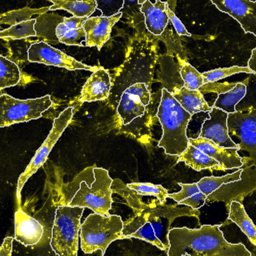
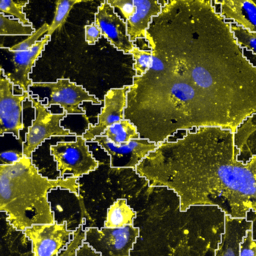
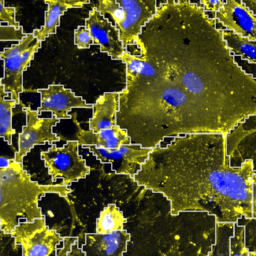
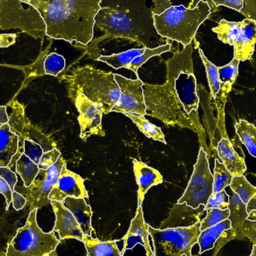
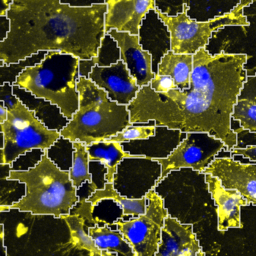
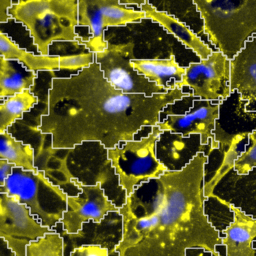

In [7]:
cell_diameters = selection_well_tiles.get("cell_diameters", [])

results_df = run_segmentation(
    selection_well_tiles,
    selected_models,
    model_dir,
    Run_directory,
    output_location,
    cell_diameters=cell_diameters,
)

display(HTML(results_df.to_html(escape=False)))

## Model by Model Comparison
- Shows 3 Bar Plots for the user to evaluate the segmentation performance.
    

C:\Users\rushikesh.dhonde\AppData\Local\Temp\ipykernel_71748\1294701084.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend().remove()  # remove duplicate legends
C:\Users\rushikesh.dhonde\AppData\Local\Temp\ipykernel_71748\1294701084.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend().remove()
C:\Users\rushikesh.dhonde\AppData\Local\Temp\ipykernel_71748\1294701084.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend().remove()


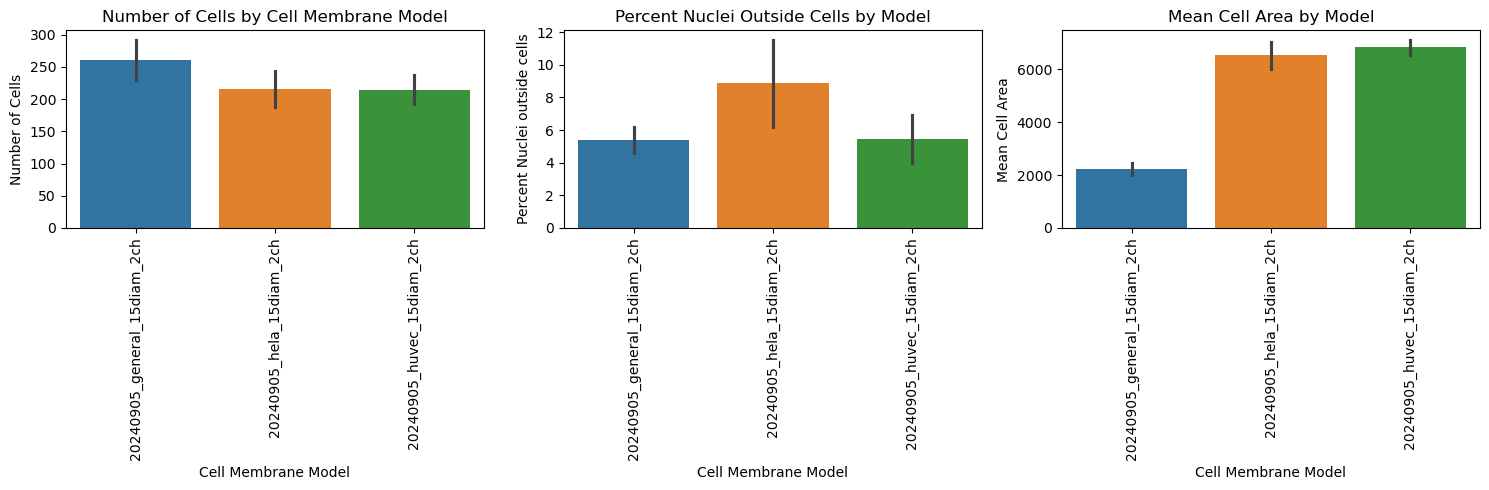

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric columns are properly typed
results_df["Percent Nuclei outside cells"] = results_df["Percent Nuclei outside cells"].astype(float)
results_df["Mean Cell Area"] = results_df["Mean Cell Area"].astype(float)

# Set up the subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Number of Cells
sns.barplot(
    data=results_df,
    x='Cell Membrane Model',
    y='Number of Cells',
    hue='Cell Membrane Model',
    ax=axes[0]
)
axes[0].set_title('Number of Cells by Cell Membrane Model')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend().remove()  # remove duplicate legends

# Plot 2: Percent Nuclei outside cells
sns.barplot(
    data=results_df,
    x='Cell Membrane Model',
    y='Percent Nuclei outside cells',
    hue='Cell Membrane Model',
    ax=axes[1]
)
axes[1].set_title('Percent Nuclei Outside Cells by Model')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend().remove()

# Plot 3: Mean Cell Area
sns.barplot(
    data=results_df,
    x='Cell Membrane Model',
    y='Mean Cell Area',
    hue='Cell Membrane Model',
    ax=axes[2]
)
axes[2].set_title('Mean Cell Area by Model')
axes[2].tick_params(axis='x', rotation=90)
axes[2].legend().remove()

plt.tight_layout()
plt.show()
